<a href="https://colab.research.google.com/github/ranesh88/Recommendation-System/blob/main/Hybrid_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Recommender System

Our goal is to create a hybrid Recommender System. From the differnt methods we have learng (Content Based & Collaborative Based (User, Item, KNN)), we will employ a total of 3 methods

In [2]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_movies = pd.read_csv('/content/movies.csv')
df_ratings = pd.read_csv('/content/ratings.csv')

In [4]:
df_movies.shape

(9125, 3)

In [6]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9125 non-null   int64 
 1   title    9125 non-null   object
 2   genres   9125 non-null   object
dtypes: int64(1), object(2)
memory usage: 214.0+ KB


In [7]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# sorted(df_movies['genres'].unique())

In [8]:
df_ratings.shape

(100004, 4)

In [9]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [10]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### Assumptions

##### 1) Both datasets do not have any null values. 
##### 2) At present, we do not need to column 'timestamp' from 'ratings.csv'. We can drop this column.
##### 3) 'moveiId' is common in both datasets. We can merge the two based on this column.
##### 

In [11]:
df_ratings.drop('timestamp', axis=1, inplace=True)

In [12]:
df = pd.merge(df_movies, df_ratings, on='movieId')

In [13]:
df

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0
...,...,...,...,...,...
99999,161944,The Last Brickmaker in America (2001),Drama,287,5.0
100000,162376,Stranger Things,Drama,73,4.5
100001,162542,Rustom (2016),Romance|Thriller,611,5.0
100002,162672,Mohenjo Daro (2016),Adventure|Drama|Romance,611,3.0


----

#### We will now create a two new column - average movie rating and the number of users who have rated that movie. With this data, we can create some visuals, and later perform Content Filtering.

In [14]:
# This loop will iterate through each row of 'df_movies'.
# We will than capture the ID of each movie.
# Using the ID, we will get the mean rating of all movies with the same ID from the new DataFrame 'df', which is a merge of 'df_movies' and 'df_ratings'

movie_ratings = []

for idx, row in df_movies.iterrows():
    value = row['movieId']
    rate = df[df['movieId'] == value]['rating'].mean()
    count = len(df[df['movieId'] == value])
    movie_ratings.append([value, rate, count])

In [22]:
ratings = pd.DataFrame(movie_ratings, columns=['movieId', 'avg_rating', 'rating_count'])

In [23]:
df_mr = ratings.merge(df_movies, on='movieId')

In [24]:
df_mr.head()

,movieId,avg_rating,rating_count,title,genres
0,1,3.872470,247,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,3.401869,107,Jumanji (1995),Adventure|Children|Fantasy
2,3,3.161017,59,Grumpier Old Men (1995),Comedy|Romance
3,4,2.384615,13,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,3.267857,56,Father of the Bride Part II (1995),Comedy


In [25]:
max(df_mr['rating_count'])

341

In [19]:
df_mr.sort_values('rating_count', ascending=False).head(10)

,movieId,avg_rating,rating_count,title,genres
321,356,4.054252,341,Forrest Gump (1994),Comedy|Drama|Romance|War
266,296,4.256173,324,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
284,318,4.487138,311,"Shawshank Redemption, The (1994)",Crime|Drama
525,593,4.138158,304,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
232,260,4.221649,291,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
427,480,3.706204,274,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
2062,2571,4.183398,259,"Matrix, The (1999)",Action|Sci-Fi|Thriller
0,1,3.872470,247,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
472,527,4.303279,244,Schindler's List (1993),Drama|War
522,589,4.006329,237,Terminator 2: Judgment Day (1991),Action|Sci-Fi


In [26]:
rating = df_mr.sort_values('rating_count', ascending=False).head(10)

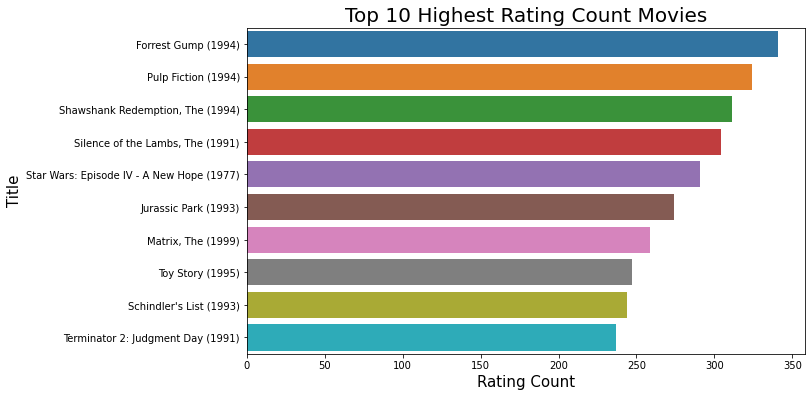

In [27]:
plt.figure(figsize=(10,6))
sns.barplot(data=rating, y='title', x='rating_count')
plt.title('Top 10 Highest Rating Count Movies', fontsize=20)
plt.xlabel('Rating Count', fontsize=15)
plt.ylabel('Title', fontsize=15)
plt.show()

---

#### We will now find out the most popular genres

In [28]:
# We will create a list of all the words mentioned under 'genres'

items = []

for idx, row in df_movies.iterrows():
    words = row['genres'].split('|')
    items.extend(words)

In [29]:
# We will extract all the unique names from the list of all words from genres.

genres = np.unique(np.array(items))
genres

array(['(no genres listed)', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'], dtype='<U18')

In [30]:
# We will create a DataFrame from the unique list of genres, and set all their values to 0.

df_genres = pd.get_dummies(genres)

for col in df_genres.columns:
    df_genres[col].values[:] = 0

In [32]:
# Each genre has been created into a new column.

df_movies = df_movies.join(df_genres)
df_movies.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy|Romance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
for idx, row in df_movies.iterrows():
    items = row['genres'].split('|')
    for col in items:
        df_movies[col][idx] = 1

In [ ]:
# Depending on the genre(s) that a movie belongs to, accordingly that genre-column will be set to a value of 1

df_movies.head()

In [34]:
# We will now add up the count of each genre where the value is 1

genre_dict = {}
i = 0

for each in genres:
    count = np.sum(df_movies[each])
    genre_dict[i] = [each, count]
    i += 1

In [35]:
genre_dict

{0: ['(no genres listed)', 18.0],
 1: ['Action', 1545.0],
 2: ['Adventure', 1117.0],
 3: ['Animation', 447.0],
 4: ['Children', 583.0],
 5: ['Comedy', 3315.0],
 6: ['Crime', 1100.0],
 7: ['Documentary', 495.0],
 8: ['Drama', 4365.0],
 9: ['Fantasy', 654.0],
 10: ['Film-Noir', 133.0],
 11: ['Horror', 877.0],
 12: ['IMAX', 153.0],
 13: ['Musical', 394.0],
 14: ['Mystery', 543.0],
 15: ['Romance', 1545.0],
 16: ['Sci-Fi', 792.0],
 17: ['Thriller', 1729.0],
 18: ['War', 367.0],
 19: ['Western', 168.0]}

In [36]:
df_gr = pd.DataFrame.from_dict(genre_dict, orient='index', columns=['Genres', 'Count'])

In [37]:
df_gr.head()

,Genres,Count
0,(no genres listed),18.0
1,Action,1545.0
2,Adventure,1117.0
3,Animation,447.0
4,Children,583.0


In [38]:
df_gr = df_gr.sort_values('Count', ascending=False)

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_gr, y='Genres', x='Count')
plt.title('Top 10 Most Popular Genres', fontsize=20)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Genres', fontsize=15)
plt.show()

#### We can see that Drama and Comedy are the most watched Genres

---

### We will now create multiple filtering systems. The results of each system will be collected and the duplicate movies will be removed.

In [39]:
# Function to return DataFrame of movies above a particular rating

def select_rating(item_id, rating):
    movie = df_mr[df_mr['movieId'] == item_id]
    return df_mr[df_mr['avg_rating'] >= rating].append(movie, ignore_index=True)

### Content Based Filtering

#### Steps
- Import modules - <br>
> from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer<br>
> from sklearn.metrics.pairwise import linear_kernel, cosine_similarity<br>
- Create an object of the Vectorizer module, and 'fit_transform' the column we want to create the filter on (in this case, it would be 'generes')</li>
- We then need to pass these values to the 'cosine_similarties' or 'linear_kernel' module
- <b><u>IMPORTANT</b></u> - Next, we iterate through the DataFrame and from the previous step, we need to match the cosine score of each movie to all the movies in the database
- A function is then created to get the name and rating of a selected movie
- Lastly, another function is created to get the recommendation based off the selected movie

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [41]:
def content_based(df_recommend, rating):
    tfid = TfidfVectorizer(stop_words='english', ngram_range=(1,3), analyzer='word')
    tfid_matrix = tfid.fit_transform(df_recommend['genres'])
    
    cos_sim = linear_kernel(tfid_matrix, tfid_matrix)
    
    results = {}
    
    for idx, row in df_recommend.iterrows():    # Iterate through the rows
        similar_indices = cos_sim[idx].argsort()[:-100:-1]
        similar_items = [(cos_sim[idx][i], df_recommend['movieId'][i], df_recommend['avg_rating'][i]) for i in similar_indices]
        results[row['movieId']] = sorted(similar_items[1:], reverse=True)
        
    return results

In [42]:
def item(df_item, id):
    name = df_item.loc[df_item['movieId'] == id]['title'].tolist()[0]
    rating = df_item.loc[df_item['movieId'] == id]['avg_rating'].tolist()[0]
    return name, rating

In [43]:
def recommend(item_id, rating, num):
    df_recommend = select_rating(item_id, rating)
    df_recommend = df_recommend.reset_index(drop=True)
    # df_recommend = df_mr
    results = content_based(df_recommend, rating)
    recs = results[item_id][:num]
    # recs = results[item_id]
    movies = []
    
    selected_movie = item(df_recommend, item_id)[0]
    print("Movie Watched : ", selected_movie)
    print()
    for rec in recs:
        # print("Recommended : " + item(df_recommend, rec[1])[0])
        # print("Rating : ", item(df_recommend, rec[1])[1])
        # print("(Score : " + str(rec[0]) + ")")
        movies.append([item(df_recommend, rec[1])[0], item(df_recommend, rec[1])[1]])
        # print()
    movies = sorted(movies, key = lambda x : x[1], reverse=True)
    print("Content Based Done!!!")
    return movies, selected_movie

In [44]:
movies_list, sel_mov = recommend(200, 4, 10)

Movie Watched :  Tie That Binds, The (1995)

Content Based Done!!!


In [45]:
sel_mov

'Tie That Binds, The (1995)'

In [46]:
movies_list

[['Borgman (2013)', 5.0],
 ['Stay (2005)', 4.5],
 ['Eye of the Needle (1981)', 4.5],
 ['Red Rock West (1992)', 4.138888888888889],
 ['Ipcress File, The (1965)', 4.0],
 ['Sabotage (1936)', 4.0],
 ['Tie That Binds, The (1995)', 4.0],
 ['Out of the Furnace (Dust to Dust) (Low Dweller, The) (2013)', 4.0],
 ['Only God Forgives (2013)', 4.0],
 ['Impossible, The (Imposible, Lo) (2012)', 4.0]]

In [47]:
movies_list, sel_mov = recommend(200, 3, 10)
sel_mov
movies_list

Movie Watched :  Tie That Binds, The (1995)

Content Based Done!!!


[['Borgman (2013)', 5.0],
 ['Best Offer, The (Migliore offerta, La) (2013)', 3.875],
 ['Spotlight (2015)', 3.8333333333333335],
 ['Guest, The (2014)', 3.8333333333333335],
 ['Stonehearst Asylum (2014)', 3.75],
 ['Blue Ruin (2013)', 3.75],
 ['10 Cloverfield Lane (2016)', 3.7],
 ['Hush (2016)', 3.5],
 ['Company You Keep, The (2012)', 3.5],
 ['Felony (2013)', 3.0]]

---

### Collaborative Based Filering - Item Based

In [48]:
def item_movie(item_id, name, top, rate):
    df_recommend = select_rating(item_id, rate)
    df_matrix = df_recommend.pivot_table(index='movieId', columns='title', values='avg_rating')
    df_matrix.fillna(0, inplace=True)
    
    movie_watched = df_matrix[name]
    similarity_scores = df_matrix.corrwith(movie_watched)
    # print(type(similarity_scores))
    top_movies = pd.DataFrame(similarity_scores.sort_values(ascending=False).head(top)[1:]).index.tolist()
    print("Collaborative Item-Based Done!!!")
    return top_movies

item_movie(2, "Jumanji (1995)", 10, 3.5)

item_movie(2, "Jumanji (1995)", 10, 3)

item_movie(2, "Jumanji (1995)", 10, 4)

---

### KNN Filtering

In [60]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

df_matrix = df_mr.pivot_table(values='avg_rating', index='title', columns='movieId')
df_matrix.fillna(0, inplace=True)
df_csr = csr_matrix(df_matrix)

In [61]:
def knn_movies(id, rate):
    df_recommend = select_rating(id, rate)
    df_matrix = df_recommend.pivot_table(values='avg_rating', index='title', columns='movieId')
    df_matrix.fillna(0, inplace=True)
    df_csr = csr_matrix(df_matrix)
    movies = []
    knn = NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)
    knn.fit(df_csr)
    df_matrix.iloc[100,:].values.reshape(1, -1)
    distance, indices = knn.kneighbors(df_matrix.iloc[100,:].values.reshape(1, -1))
    for each in indices:
        # print(df_matrix.index[each])
        movies.append(df_matrix.index[each])
    print("KNN Based Done!!!")
    return movies

In [62]:
knn_selection = knn_movies(200, 3)

KNN Based Done!!!


In [63]:
for each in knn_selection:
    for mov in each:
        print(mov)

9 1/2 Weeks (Nine 1/2 Weeks) (1986)
Paris Is Burning (1990)
Paradise Now (2005)
Paradise Lost: The Child Murders at Robin Hood Hills (1996)
Parallax View, The (1974)
Paragraph 175 (2000)
Parenthood (1989)
Passion of Mind (2000)
Paris, France (1993)
Paris, I Love You (Paris, je t'aime) (2006)
Paris, Texas (1984)
Partly Cloudy (2009)
Party, The (1968)
Passage to India, A (1984)
Passenger 57 (1992)
Passenger, The (Professione: reporter) (1975)
Passion Fish (1992)
Parent Trap, The (1998)
Paradise Road (1997)
Past, The (Le passé) (2013)


---

### Function for a Hybrid Recommender System

In [53]:
def hybrid_rec_sys(item_id, rating, items):
    all_movies = []
   
    movies_list, sel_mov = recommend(item_id, rating, items)
    item_mov = item_movie(item_id, sel_mov, items, rating)
    knn_mov = knn_movies(item_id, rating)
    
    all_movies = sorted([each[0] for each in movies_list] + item_mov + [mov for knn_each in knn_mov for mov in knn_each])
    all_movies = np.unique(all_movies)
    mov_rating = []
    
    for each in all_movies:
        value = df_mr[df_mr['title'] == each]['avg_rating']
        mov_rating.append([each, round(value.iloc[0],2)])
    
    recommended_movies = pd.DataFrame(mov_rating, columns=['Title', 'Rating'])
    return recommended_movies.sort_values('Rating', ascending=False)

In [54]:
top = 15
final_movies = hybrid_rec_sys(200, 4, top)
final_movies.head(top)
# final_movies

Movie Watched :  Tie That Binds, The (1995)

Content Based Done!!!
Collaborative Item-Based Done!!!
KNN Based Done!!!


,Title,Rating
0,Amazing Grace (2006),5.0
15,Losing Chase (1996),5.0
47,"Unvanquished, The (Aparajito) (1957)",5.0
44,State of Siege (État de siège) (1972),5.0
43,"Secret, The (2006)",5.0
40,Prisoner of the Mountains (Kavkazsky plennik) ...,5.0
28,"Play House, The (1921)",5.0
1,Angel Baby (1995),5.0
22,Phantom of the Paradise (1974),5.0
21,Phantasm II (1988),5.0


In [55]:
final_movies = hybrid_rec_sys(20, 4, top)
final_movies.head(top)
# final_movies

Movie Watched :  Money Train (1995)

Content Based Done!!!
Collaborative Item-Based Done!!!
KNN Based Done!!!


,Title,Rating
44,Supercop 2 (Project S) (Chao ji ji hua) (1993),5.00
23,Phantasm II (1988),5.00
30,"Play House, The (1921)",5.00
7,Cul-de-sac (1966),5.00
15,Knockin' on Heaven's Door (1997),5.00
25,"Pirate Movie, The (1982)",4.50
12,Find Me Guilty (2006),4.50
39,"Pompatus of Love, The (1996)",4.50
1,49 Up (2005),4.38
13,Hearts of Darkness: A Filmmakers Apocalypse (1...,4.38


In [56]:
final_movies = hybrid_rec_sys(200, 3, top)
final_movies.head(top)
# final_movies

Movie Watched :  Tie That Binds, The (1995)

Content Based Done!!!
Collaborative Item-Based Done!!!
KNN Based Done!!!


,Title,Rating
39,"Past, The (Le passé) (2013)",5.00
29,"Paris, France (1993)",5.00
34,"Passage to India, A (1984)",5.00
6,Borgman (2013),5.00
32,Partly Cloudy (2009),4.75
22,Paradise Now (2005),4.67
36,"Passenger, The (Professione: reporter) (1975)",4.50
44,Stay (2005),4.50
28,Paris Is Burning (1990),4.39
31,"Paris, Texas (1984)",4.29


In [57]:
final_movies = hybrid_rec_sys(100, 4, top)
final_movies.head(top)
# final_movies

Movie Watched :  City Hall (1996)

Content Based Done!!!
Collaborative Item-Based Done!!!
KNN Based Done!!!


,Title,Rating
24,Phantasm II (1988),5.00
43,State of Siege (État de siège) (1972),5.00
30,"Play House, The (1921)",5.00
19,Neighbouring Sounds (O som ao redor) (2012),5.00
46,Ugetsu (Ugetsu monogatari) (1953),4.75
15,Love & Human Remains (1993),4.70
9,"Debt, The (2011)",4.50
39,"Pompatus of Love, The (1996)",4.50
25,"Pirate Movie, The (1982)",4.50
0,23 (23 - Nichts ist so wie es scheint) (1998),4.50


In [58]:
final_movies = hybrid_rec_sys(150, 4, top)
final_movies.head(top)
# final_movies

Movie Watched :  Apollo 13 (1995)

Content Based Done!!!
Collaborative Item-Based Done!!!
KNN Based Done!!!


,Title,Rating
43,Secretariat (2010),5.0
18,"Passage to India, A (1984)",5.0
27,"Play House, The (1921)",5.0
39,Prisoner of the Mountains (Kavkazsky plennik) ...,5.0
20,Phantasm II (1988),5.0
42,"Secret, The (2006)",5.0
12,Message to Love: The Isle of Wight Festival (1...,5.0
1,Angel Baby (1995),5.0
45,"Two Escobars, The (2010)",5.0
9,Howl (2010),5.0


In [59]:
final_movies = hybrid_rec_sys(5, 4.5, top)
final_movies.head(top)
# final_movies

Movie Watched :  Father of the Bride Part II (1995)

Content Based Done!!!
Collaborative Item-Based Done!!!
KNN Based Done!!!


,Title,Rating
17,George Carlin: Life Is Worth Losing (2005),5.0
43,Reality (2014),5.0
33,"Patience Stone, The (2012)",5.0
31,"Past, The (Le passé) (2013)",5.0
39,Peter Pan (1960),5.0
29,"Passage to India, A (1984)",5.0
27,"Paris, France (1993)",5.0
40,Phantasm II (1988),5.0
1,29th and Gay (2005),5.0
18,George Carlin: You Are All Diseased (1999),5.0


---